## Temporal Fusion Transformers
<a target="_blank" href="https://colab.research.google.com/github/AI4FinTech/FinTorch/tree/main/docs/tutorials/tft/tft.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The Temporal Fusion Transformer (TFT) is a cutting-edge deep learning model designed for interpretable, multi-horizon time series forecasting. Developed by Google in collaboration with the University of Oxford, TFT combines the strengths of recurrent layers for local processing and self-attention layers for capturing long-term dependencies [[1](https://arxiv.org/abs/1912.09363)][[2](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Forecasting/TFT/README.md)]. This hybrid architecture allows TFT to effectively handle complex temporal relationships and select relevant features, making it highly versatile across various forecasting scenarios [[1](https://arxiv.org/abs/1912.09363)]. Its ability to provide interpretable insights into temporal dynamics and deliver high-performance predictions sets it apart as a powerful tool for time series analysis [[1](https://arxiv.org/abs/1912.09363)][[2](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Forecasting/TFT/README.md)].


## Datasets
In this tutorial, we will explore the application of the Temporal Fusion Transformer (TFT) model to various time series datasets, including synthetic, air passenger, electricity consumption, and stock market data. The TFT model, known for its ability to handle complex temporal relationships and provide interpretable insights, is particularly well-suited for these diverse datasets. We will start with the SimpleSyntheticDataset, which generates synthetic time series data with configurable trend, seasonality, and noise components, making it ideal for testing forecasting models. Next, we will use the Air Passenger dataset, which contains monthly totals of international airline passengers from 1949 to 1960, normalized for effective model training. We will also analyze the PJM Hourly Energy Consumption dataset, which provides hourly power consumption data from a regional transmission organization in the United States. Finally, we will apply the TFT model to stock market data obtained from Yahoo Finance, allowing us to forecast stock prices based on historical trends. By the end of this tutorial, you will have a comprehensive understanding of how to leverage the TFT model for various time series forecasting tasks.

### Simple Synthetic
First, let's import the necessary libraries and define our hyperparameters.



In [1]:
import os
import lightning as L
import matplotlib.pyplot as plt
import torch
from lightning.pytorch.callbacks import EarlyStopping
from fintorch.datasets.synthetic import SimpleSyntheticDataModule
from fintorch.models.timeseries.tft import (
    GatedResidualNetwork,
    InterpretableMultiHeadAttention,
    TemporalFusionTransformer,
    TemporalFusionTransformerModule,
    VariableSelectionNetwork,
)

# Define hyperparameters
input_dimensions = 10
hidden_dimensions = 64
dropout = 0.1
context_size = 5
batch_size = 32
sequence_length = 10
num_inputs = 3
number_of_heads = 4

/Users/mboersma/Documents/AI4Fintech/FinTorch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-31 12:10:09,000	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-31 12:10:10,055	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


We will start by using the Gated Residual Network (GRN). The GRN is a key component of the TFT model, allowing it to handle complex temporal relationships.



In [2]:
# Example usage of GatedResidualNetwork
context = torch.randn(batch_size, context_size)
grn = GatedResidualNetwork(
    input_size=input_dimensions,
    hidden_size=hidden_dimensions,
    output_size=hidden_dimensions,
    dropout=dropout,
    context_size=context_size,
)
grn_input = torch.randn(batch_size, sequence_length, input_dimensions)
grn_output = grn(grn_input, context)
print("GRN Output shape:", grn_output.shape)

GRN Output shape: torch.Size([32, 10, 64])


Next, we will use the Variable Selection Network (VSN) to select relevant features from the input data.

In [3]:
# Example usage of VariableSelectionNetwork
variable_selection_network = VariableSelectionNetwork(
    {"a": 3, "b": 4, "c": 5}, hidden_dimensions, dropout, context_size
)

# Create example input data
x_a = torch.randn(batch_size, sequence_length, 3)
x_b = torch.randn(batch_size, sequence_length, 4)
x_c = torch.randn(batch_size, sequence_length, 5)
inputs = {"a": x_a, "b": x_b, "c": x_c}

print("Shape of x_a:", x_a.shape)
print("Shape of x_b:", x_b.shape)
print("Shape of x_c:", x_c.shape)

# Call the forward method
vsn_output = variable_selection_network(inputs, context)

# Print the output shape
print("VSN output shape:", vsn_output.shape)

Shape of x_a: torch.Size([32, 10, 3])
Shape of x_b: torch.Size([32, 10, 4])
Shape of x_c: torch.Size([32, 10, 5])
VSN output shape: torch.Size([32, 10, 64])


We will then use the Interpretable Multi-Head Attention mechanism to capture long-term dependencies in the data.

In [4]:
# Example usage of InterpretableMultiHeadAttention
attention_module = InterpretableMultiHeadAttention(
    number_of_heads, hidden_dimensions, dropout
)

# Generate example input tensors
q = grn_output  # Use output of GRN as query
k = grn_output  # Use output of GRN as key
v = grn_output  # Use output of GRN as value

# Create a mask (optional)
mask = torch.tril(torch.ones(sequence_length, sequence_length)).bool()

# Call the forward method of InterpretableMultiHeadAttention
attention_output, attentions = attention_module(q, k, v, mask)

# Print the output shapes
print("Attention Output shape:", attention_output.shape)
print("Attentions shape:", attentions.shape)

Attention Output shape: torch.Size([32, 10, 64])
Attentions shape: torch.Size([32, 4, 10, 10])


We can also use the output of the VSN as input to the attention mechanism.

In [5]:
# Example of using the InterpretableMultiHeadAttention after the variable selection network
q = vsn_output  # Using the output of the vsn.
k = vsn_output  # Using the output of the vsn.
v = vsn_output  # Using the output of the vsn.

attention_output, attentions = attention_module(q, k, v, mask)

# Print the output shapes
print("Attention Output shape after the vsn:", attention_output.shape)
print("Attentions shape after the vsn:", attentions.shape)

Attention Output shape after the vsn: torch.Size([32, 10, 64])
Attentions shape after the vsn: torch.Size([32, 4, 10, 10])


Finally, let's visualize the attention maps to understand how the model is attending to different parts of the input sequence.

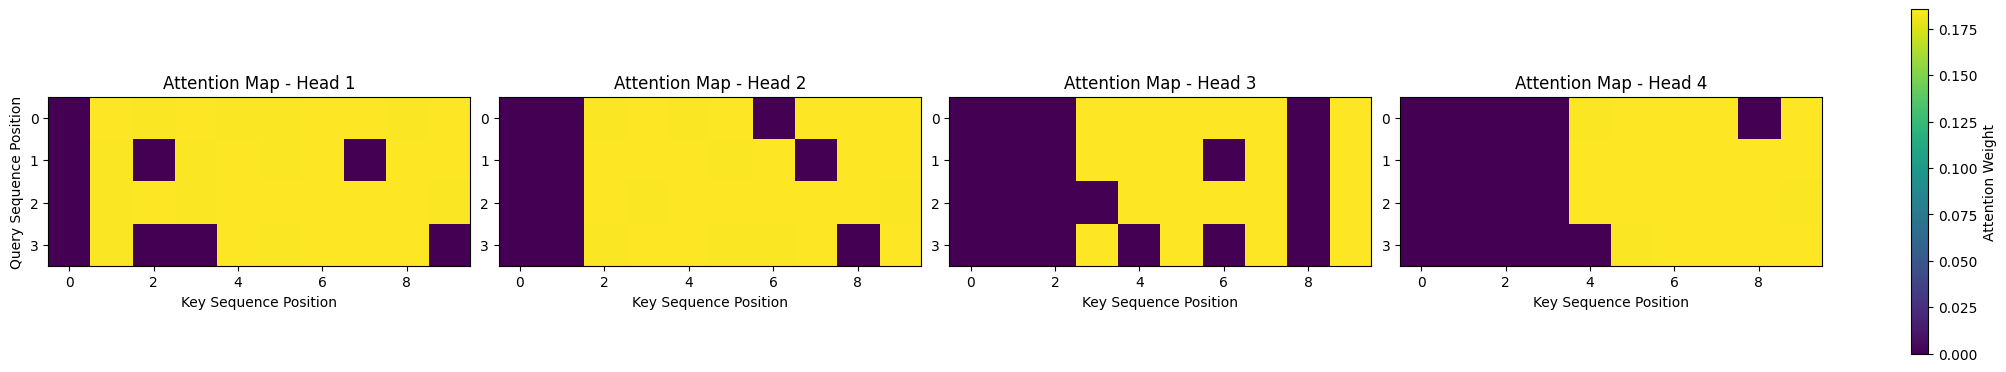

In [6]:
# Example of plotting the attention maps per head
batch_index = 0
fig, axes = plt.subplots(
    1, number_of_heads, figsize=(5 * number_of_heads, 5), constrained_layout=True
)

for head in range(number_of_heads):
    attention_map = attentions[batch_index, :, head, :].detach().cpu().numpy()
    ax = axes[head] if number_of_heads > 1 else axes

    # Plot the attention map as a heatmap
    im = ax.imshow(attention_map, cmap="viridis")

    # Set labels and title
    ax.set_xlabel("Key Sequence Position")
    if head == 0:
        ax.set_ylabel("Query Sequence Position")
    ax.set_title(f"Attention Map - Head {head+1}")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, label="Attention Weight")
plt.show()

Next, we will train the TFT model.

In [7]:
import os
import lightning as L
import matplotlib.pyplot as plt
import torch
from lightning.pytorch.callbacks import EarlyStopping
from fintorch.datasets.synthetic import SimpleSyntheticDataModule
from fintorch.models.timeseries.tft import (
    GatedResidualNetwork,
    InterpretableMultiHeadAttention,
    TemporalFusionTransformer,
    TemporalFusionTransformerModule,
    VariableSelectionNetwork,
)

# Define hyperparameters
input_dimensions = 10
hidden_dimensions = 64
dropout = 0.1
context_size = 5
batch_size = 32
sequence_length = 10
num_inputs = 3
number_of_heads = 4

We will start by using the Temporal Fusion Transformer (TFT) model. The TFT model is designed to handle complex temporal relationships and provide interpretable insights into time series data.

In [8]:
print("####### TFT ########")

# Example usage of TemporalFusionTransformer
# Define hyperparameters
embedding_size_inputs = 64
hidden_dimension = 64
dropout = 0.1
number_of_heads = 4
past_inputs = {"a": 3, "b": 4, "c": 5}
future_inputs = {"d": 2, "e": 3}
static_inputs = {"f": 4, "g": 5}
quantiles = [0.05, 0.5, 0.95]
sequence_length_past = 6
sequence_length_future = 2

# Create an instance of TemporalFusionTransformer
tft_model = TemporalFusionTransformer(
    sequence_length_past,
    sequence_length_future,
    embedding_size_inputs,
    hidden_dimension,
    dropout,
    number_of_heads,
    past_inputs,
    future_inputs,
    static_inputs,
    quantiles=quantiles,
    batch_size=batch_size,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

# Generate example input tensors
past_inputs_tensor = {
    "a": torch.randn(batch_size, sequence_length_past, 3),
    "b": torch.randn(batch_size, sequence_length_past, 4),
    "c": torch.randn(batch_size, sequence_length_past, 5),
}
future_inputs_tensor = {
    "d": torch.randn(batch_size, sequence_length_future, 2),
    "e": torch.randn(batch_size, sequence_length_future, 3),
}
static_inputs_tensor = {
    "f": torch.randn(batch_size, 4),
    "g": torch.randn(batch_size, 5),
}

# Call the forward method of TemporalFusionTransformer
tft_output, attention_weights = tft_model(
    past_inputs_tensor, future_inputs_tensor, static_inputs_tensor
)

# Print the output shapes
print(
    "TFT Output shape[batch size, horizon, number of targets=1, number of quantiles]:",
    tft_output.shape,
)
print(f"past length: {sequence_length_past} future length: {sequence_length_future}")
print(
    "Attention Weights shape[batch size, heads, sequence length (past length + future length),"
    + " sequence length (past length + future length)]:",
    attention_weights.shape,
)

####### TFT ########
TFT Output shape[batch size, horizon, number of targets=1, number of quantiles]: torch.Size([32, 2, 1, 3])
past length: 6 future length: 2
Attention Weights shape[batch size, heads, sequence length (past length + future length), sequence length (past length + future length)]: torch.Size([32, 4, 8, 8])


Next, we will use the Temporal Fusion Transformer Module (TFT Module), which is a more modular and flexible implementation of the TFT model.

In [9]:
# Example usage of TemporalFusionTransformerModule
# Define hyperparameters
sequence_length_past = 3
number_of_future_inputs = 2
embedding_size_inputs = 64
hidden_dimension = 64
dropout = 0.1
number_of_heads = 4
past_inputs = {"a": 3, "b": 4, "c": 5}
future_inputs = {"d": 2, "e": 3}
static_inputs = {"f": 4, "g": 5}
sequence_length_future = 2

# Create an instance of TemporalFusionTransformerModule
tft_module = TemporalFusionTransformerModule(
    sequence_length_past,
    sequence_length_future,
    embedding_size_inputs,
    hidden_dimension,
    dropout,
    number_of_heads,
    past_inputs,
    future_inputs,
    static_inputs,
    quantiles=quantiles,
    batch_size=batch_size,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

# Generate example input tensors
past_inputs_tensor = {
    "a": torch.randn(batch_size, sequence_length_past, 3),
    "b": torch.randn(batch_size, sequence_length_past, 4),
    "c": torch.randn(batch_size, sequence_length_past, 5),
}
future_inputs_tensor = {
    "d": torch.randn(batch_size, sequence_length_future, 2),
    "e": torch.randn(batch_size, sequence_length_future, 3),
}
static_inputs_tensor = {
    "f": torch.randn(batch_size, 4),
    "g": torch.randn(batch_size, 5),
}
target = torch.randn(batch_size, sequence_length_future).float()

# Create a batch
batch = (past_inputs_tensor, future_inputs_tensor, static_inputs_tensor, target)

# Call the forward method of TemporalFusionTransformerModule
tft_module_output, attention_weights = tft_module(
    past_inputs_tensor, future_inputs_tensor, static_inputs_tensor
)

# Print the output shapes
print("TFT Module Output shape:", tft_module_output.shape)
print("Attention Weights shape:", attention_weights.shape)

# Call the training step
loss = tft_module.training_step(batch, 0)
print("Loss:", loss)

# Call the validation step
loss = tft_module.validation_step(batch, 0)
print("Loss:", loss)

# Call the test step
loss = tft_module.test_step(batch, 0)
print("Loss:", loss)

# Call the predict step
output = tft_module.predict_step(batch, 0)
print("Prediction:", output.shape)

TFT Module Output shape: torch.Size([32, 2, 1, 3])
Attention Weights shape: torch.Size([32, 4, 5, 5])
Loss: tensor(0.8815, grad_fn=<MeanBackward0>)
Loss: tensor(0.8599, grad_fn=<MeanBackward0>)
Loss: tensor(0.8553, grad_fn=<MeanBackward0>)
Prediction: torch.Size([32, 2, 1, 3])


/Users/mboersma/Documents/AI4Fintech/FinTorch/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Finally, we will train the TFT Module using the SimpleSyntheticDataModule, which generates synthetic time series data for training, validation, and testing.

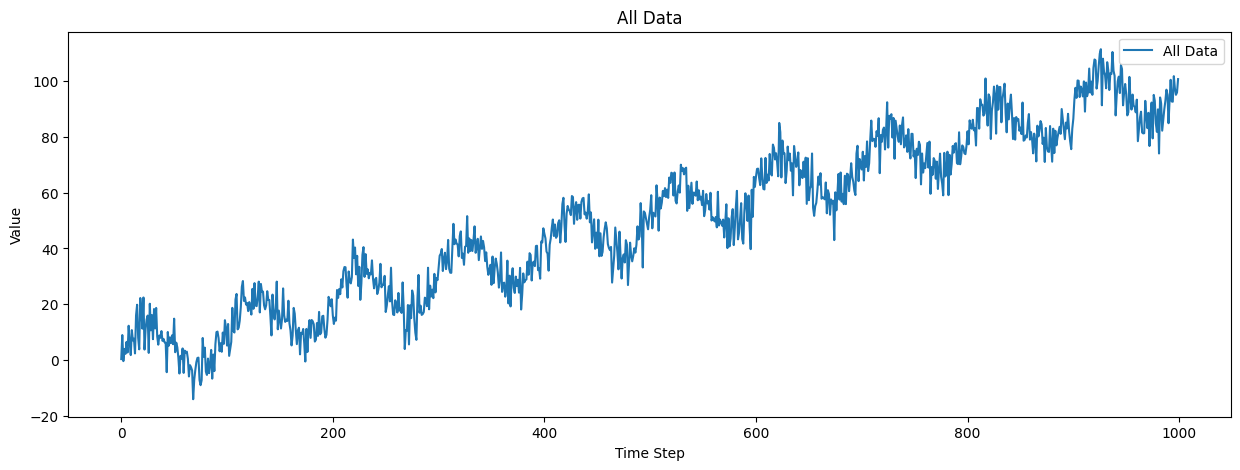

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 75.9 K | train
----------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.304     Total estimated model params size (MB)
140       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s, v_num=1]          

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 31/31 [00:18<00:00,  1.64it/s, v_num=1]


/Users/mboersma/Documents/AI4Fintech/FinTorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 63.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    6.9318037033081055     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.9318037033081055}]

In [11]:
# Define hyperparameters
static_length = 2
past_inputs = 1
future_inputs = 1
noise_level = 5
trend_slope = 0.1
seasonality_amplitude = 10
seasonality_period = 100
batch_size = 32

number_of_past_inputs = 24
number_of_future_inputs = 12
embedding_size_inputs = hidden_dimension = 32
dropout = 0.5
number_of_heads = 1
past_inputs = {"past_data": past_inputs}
future_inputs = {"future_data": future_inputs}
static_inputs = {"static_data": static_length}

# Create an instance of TemporalFusionTransformerModule
tft_module = TemporalFusionTransformerModule(
    number_of_past_inputs,
    number_of_future_inputs,
    embedding_size_inputs,
    hidden_dimension,
    dropout,
    number_of_heads,
    past_inputs,
    future_inputs,
    static_inputs,
    batch_size=batch_size,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

# Create an instance of SimpleSyntheticDataModule
data_module = SimpleSyntheticDataModule(
    train_length=1000,
    val_length=100,
    test_length=100,
    batch_size=batch_size,
    noise_level=noise_level,
    past_length=number_of_past_inputs,
    future_length=number_of_future_inputs,
    static_length=static_length,
    trend_slope=trend_slope,
    seasonality_amplitude=seasonality_amplitude,
    seasonality_period=seasonality_period,
    workers=os.cpu_count(),
)

# Set the precision
torch.set_float32_matmul_precision("medium")

# Prepare the data
data_module.setup()

plot_all_data = data_module.train_dataset.data

# Plot all data
plt.figure(figsize=(15, 5))
plt.plot(plot_all_data, label="All Data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("All Data")
plt.legend()
plt.show()

train_dataloader = data_module.train_dataloader()

# Create a trainer with TensorBoard for better monitoring
early_stopping = EarlyStopping("val_loss_epoch", patience=50)
trainer = L.Trainer(max_epochs=1, callbacks=[early_stopping])

# Train the model
trainer.fit(tft_module, data_module)
trainer.test(tft_module, data_module)

Next, we take a couple of random batches and plot the predicted values.

In [14]:
from random import randint
# Get predictions
predictions = trainer.predict(tft_module, datamodule=data_module)

# Concatenate predictions
all_predictions = torch.cat(predictions, dim=0)

# Number of batches to plot
num_batches_to_plot = 5

# Plotting
plt.figure(figsize=(15, 5 * num_batches_to_plot))  # Adjust figure size

for idx in range(0, num_batches_to_plot):
    batch_idx = randint(0, len(all_predictions) - 1)

    selected_batch_predictions = all_predictions[batch_idx]
    _, _, _, selected_batch_target = data_module.test_dataset[batch_idx]

    selected_batch_predictions_inverse_scaled = (
        data_module.dataset.scaler.inverse_transform(
            selected_batch_predictions.reshape(-1, selected_batch_predictions.shape[-1])
        ).reshape(selected_batch_predictions.shape)
    )

    selected_batch_target_inverse_scaled = data_module.dataset.scaler.inverse_transform(
        selected_batch_target.reshape(-1, 1)
    ).reshape(selected_batch_target.shape)

    plt.subplot(
        num_batches_to_plot,
        1,
        idx + 1,
    )  # Create subplots

    plt.plot(
        selected_batch_target_inverse_scaled, label="Target", marker="o", linestyle="-"
    )

    for i, quantile in enumerate(quantiles):
        plt.plot(
            selected_batch_predictions_inverse_scaled[:, 0, i],
            label=f"Predicted Quantile {quantile}",
            marker="x",
            linestyle="--",
        )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Target vs Predicted Quantiles for Batch {batch_idx + 1}")
    plt.legend()

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()


/Users/mboersma/Documents/AI4Fintech/FinTorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 86.53it/s]


AttributeError: 'SimpleSyntheticDataModule' object has no attribute 'dataset'

<Figure size 1500x2500 with 0 Axes>

We now succesfully trained a TFT model on the synthetic dataset

### Electricity

The electricity dataset is a widely used benchmark for time series forecasting tasks. It contains hourly electricity consumption data from various households, providing a rich and diverse set of temporal patterns. In this tutorial, we will leverage the Temporal Fusion Transformer (TFT) model to forecast electricity consumption. The TFT model's ability to handle complex temporal relationships and provide interpretable insights makes it an excellent choice for this dataset. By the end of this section, you will learn how to preprocess the electricity dataset, train the TFT model, and evaluate its performance on forecasting tasks.

Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)


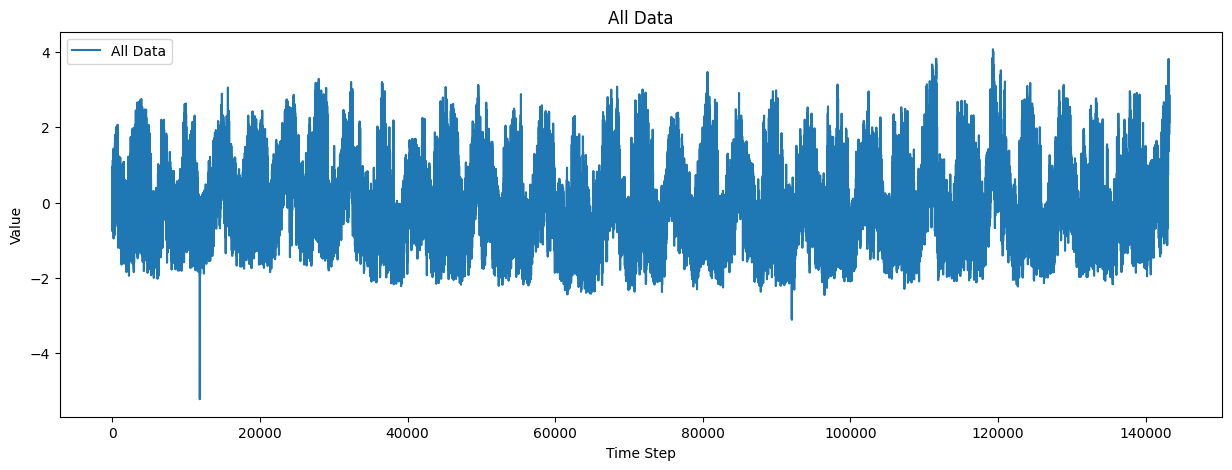

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)



  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 1.4 M  | train
----------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.523     Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode


Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mboersma/Documents/AI4Fintech/FinTorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [17]:
import os

import lightning as L
import matplotlib.pyplot as plt
import torch
from lightning.pytorch.callbacks import EarlyStopping

from fintorch.datasets.electricity_simple import ElectricityDataModule
from fintorch.models.timeseries.tft import TemporalFusionTransformerModule

# Define hyperparameters
number_of_past_inputs = 168
number_of_future_inputs = 24
embedding_size_inputs = hidden_dimension = 160
dropout = 0.1
number_of_heads = 4
batch_size = 1024


past_inputs = {"past_data": 1}
future_inputs = None
static_inputs = None
quantiles = [0.05, 0.5, 0.95]


# Create an instance of TemporalFusionTransformerModule
tft_module = TemporalFusionTransformerModule(
    number_of_past_inputs,
    number_of_future_inputs,
    embedding_size_inputs,
    hidden_dimension,
    dropout,
    number_of_heads,
    past_inputs,
    future_inputs,
    static_inputs,
    batch_size=batch_size,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    quantiles=quantiles,
)

data_module = ElectricityDataModule(
    batch_size=batch_size,
    past_length=number_of_past_inputs,
    horizon=number_of_future_inputs,
    workers=os.cpu_count(),
)

# Set the precision
torch.set_float32_matmul_precision("medium")

# Prepare the data
data_module.setup()


plot_all_data = data_module.train_dataset.data

# Plot all data
plt.figure(figsize=(15, 5))
plt.plot(plot_all_data, label="All Data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("All Data")
plt.legend()
plt.show()

# Create a trainer with TensorBoard for better monitoring
early_stopping = EarlyStopping("val_loss_epoch", patience=50)
trainer = L.Trainer(
    max_epochs=1,
    callbacks=[early_stopping],
    gradient_clip_val=0.01,
)

# Train the model
trainer.fit(tft_module, data_module)

trainer.test(tft_module, data_module)


And we will evaluate the prediction with a plot of some randomly selected batches

In [18]:
# Get predictions
predictions = trainer.predict(tft_module, datamodule=data_module)

# Concatenate predictions
all_predictions = torch.cat(predictions, dim=0)

# Number of batches to plot
num_batches_to_plot = 5

# Plotting
plt.figure(figsize=(15, 5 * num_batches_to_plot))  # Adjust figure size

for idx in range(0, num_batches_to_plot):
    batch_idx = randint(0, len(all_predictions) - 1)

    selected_batch_predictions = all_predictions[batch_idx]
    _, selected_batch_target = data_module.test_dataset[batch_idx]

    selected_batch_predictions_inverse_scaled = (
        data_module.dataset.scaler.inverse_transform(
            selected_batch_predictions.reshape(-1, selected_batch_predictions.shape[-1])
        ).reshape(selected_batch_predictions.shape)
    )

    selected_batch_target_inverse_scaled = data_module.dataset.scaler.inverse_transform(
        selected_batch_target.reshape(-1, 1)
    ).reshape(selected_batch_target.shape)

    plt.subplot(
        num_batches_to_plot,
        1,
        idx + 1,
    )  # Create subplots

    plt.plot(
        selected_batch_target_inverse_scaled, label="Target", marker="o", linestyle="-"
    )

    for i, quantile in enumerate(quantiles):
        plt.plot(
            selected_batch_predictions_inverse_scaled[:, 0, i],
            label=f"Predicted Quantile {quantile}",
            marker="x",
            linestyle="--",
        )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Target vs Predicted Quantiles for Batch {batch_idx + 1}")
    plt.legend()

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()


Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)
Electricity dataset size: (143206, 2)


/Users/mboersma/Documents/AI4Fintech/FinTorch/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
### Fitting the Temporal Fusion Transformer (TFT) Model on the StockTick Dataset

The stock market is a highly dynamic and complex system, making accurate forecasting a challenging task. The StockTick dataset provides historical stock price data, which can be leveraged to predict future trends and movements. In this section, we will utilize the Temporal Fusion Transformer (TFT) model, a state-of-the-art deep learning architecture designed for interpretable, multi-horizon time series forecasting. The TFT model's ability to handle complex temporal relationships, select relevant features, and provide interpretable insights makes it an excellent choice for stock price forecasting.

We will preprocess the StockTick dataset, define the necessary hyperparameters, and train the TFT model to predict future stock prices. By the end of this section, we will evaluate the model's performance and visualize its predictions, gaining valuable insights into the temporal dynamics of stock price movements.

In [ ]:
import logging
from datetime import date
from pathlib import Path
from random import randint

import lightning as L
import matplotlib.pyplot as plt
import torch
from lightning.pytorch.callbacks import EarlyStopping

from fintorch.datasets import stockticker
from fintorch.datasets.stockticker import StockTickerDataModule
from fintorch.models.timeseries.tft import TemporalFusionTransformerModule

# Set logging level to INFO
logging.basicConfig(level=logging.INFO)

We will define the parameters for loading the stock ticker data and setting up the TFT model.

In [ ]:
# Parameters
tickers = ["AAPL"]
data_path = Path("~/.fintorch_data/stocktickers/").expanduser()
start_date = date(2015, 1, 1)
end_date = date(2024, 6, 30)

# Create a dictionary mapping from tickers to index
ticker_index = {ticker: index for index, ticker in enumerate(tickers)}

Next, we will load the stock dataset using the StockTicker class.

In [ ]:
# Load the stock dataset
stockdata = stockticker.StockTicker(
    data_path,
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    mapping=ticker_index,
    force_reload=False,
)

print(stockdata.df_timeseries_dataset.to_pandas().describe())

We will define the hyperparameters for the TFT model and create a data module for handling the stock ticker data.

In [ ]:
number_of_past_inputs = 168
number_of_future_inputs = 24
embedding_size_inputs = hidden_dimension = 80
dropout = 0.1
number_of_heads = 2
batch_size = 1024

# Create a datamodule
datamodule = StockTickerDataModule(
    data_path=data_path,
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    ticker_index=ticker_index,
    batch_size=batch_size,
    workers=0,
    past_length=number_of_past_inputs,
    future_length=number_of_future_inputs,
)

# Setup the datamodule
datamodule.setup()

We will inspect the first few batches of the training dataset to understand the shape of the input data.

In [ ]:
# Iterate over the first 3 batches of the train dataset
for batch_idx, (past_inputs, target) in enumerate(datamodule.train_dataloader()):
    if batch_idx >= 3:
        break
    print(f"Batch {batch_idx + 1}:")
    print(f"  Past Inputs shape: {past_inputs['past_data'].shape}")
    print(f"  Target shape: {target.shape}")

We will create an instance of the TemporalFusionTransformerModule and set the precision for matrix multiplication.

In [ ]:
past_inputs = {"past_data": 1}
future_inputs = None
static_inputs = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

quantiles = [0.05, 0.5, 0.95]

# Create an instance of TemporalFusionTransformerModule
tft_module = TemporalFusionTransformerModule(
    number_of_past_inputs,
    number_of_future_inputs,
    embedding_size_inputs,
    hidden_dimension,
    dropout,
    number_of_heads,
    past_inputs,
    future_inputs,
    static_inputs,
    batch_size=batch_size,
    device=device,
    quantiles=quantiles,
).to(device)

# Set the precision
torch.set_float32_matmul_precision("medium")

We will plot the entire dataset to visualize the stock price trends.

In [ ]:
plot_all_data = datamodule.train_dataset.df_timeseries_dataset.select("y")
plot_all_data = plot_all_data.to_series().to_list()

# Plot all data
plt.figure(figsize=(15, 5))
plt.plot(plot_all_data, label="All Data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("All Data")
plt.legend()
plt.show()

We will create a trainer with early stopping and train the TFT model using the stock ticker data.



In [ ]:
# Create a trainer with TensorBoard for better monitoring
early_stopping = EarlyStopping("val_loss_epoch", patience=100)
trainer = L.Trainer(max_epochs=500, callbacks=[early_stopping], log_every_n_steps=4)

# Train the model
trainer.fit(tft_module, datamodule=datamodule)

trainer.test(tft_module, datamodule=datamodule)

We will get predictions from the trained model and plot the predicted quantiles against the actual targets.



In [ ]:
# Get predictions
predictions = trainer.predict(tft_module, datamodule=datamodule)

# Concatenate predictions
all_predictions = torch.cat(predictions, dim=0)

# Number of batches to plot
num_batches_to_plot = 5

# Plotting
plt.figure(figsize=(15, 5 * num_batches_to_plot))  # Adjust figure size

for idx in range(0, num_batches_to_plot):
    batch_idx = randint(0, len(all_predictions) - 1)

    selected_batch_predictions = all_predictions[batch_idx]
    _, selected_batch_target = datamodule.test_dataset[batch_idx]

    selected_batch_predictions_inverse_scaled = (
        datamodule.dataset.scaler.inverse_transform(
            selected_batch_predictions.reshape(-1, selected_batch_predictions.shape[-1])
        ).reshape(selected_batch_predictions.shape)
    )

    selected_batch_target_inverse_scaled = datamodule.dataset.scaler.inverse_transform(
        selected_batch_target.reshape(-1, 1)
    ).reshape(selected_batch_target.shape)

    plt.subplot(
        num_batches_to_plot,
        1,
        idx + 1,
    )  # Create subplots

    plt.plot(
        selected_batch_target_inverse_scaled, label="Target", marker="o", linestyle="-"
    )

    for i, quantile in enumerate(quantiles):
        plt.plot(
            selected_batch_predictions_inverse_scaled[:, 0, i],
            label=f"Predicted Quantile {quantile}",
            marker="x",
            linestyle="--",
        )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Target vs Predicted Quantiles for Batch {batch_idx + 1}")
    plt.legend()

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()


## Conclusion
In this tutorial, we explored the Temporal Fusion Transformer (TFT) model, a powerful and interpretable deep learning architecture for multi-horizon time series forecasting. We demonstrated its application on various datasets, including synthetic, electricity consumption, and stock market data. Through the use of key components such as the Gated Residual Network (GRN), Variable Selection Network (VSN), and Interpretable Multi-Head Attention, we showcased how the TFT model effectively handles complex temporal relationships and selects relevant features. Additionally, we visualized attention maps and evaluated the model's predictions, gaining valuable insights into its interpretability and performance. By the end of this tutorial, you should have a solid understanding of how to leverage the TFT model for diverse time series forecasting tasks.

## References
- Lim, Bryan, Sercan O. Arik, Nicolas Loeff, and Tomas Pfister. 2019. “Temporal Fusion Transformers for Interpretable Multi-Horizon Time Series Forecasting.” arXiv [Stat.ML]. arXiv. http://arxiv.org/abs/1912.09363.
